# DTW Distance Calculation on Raw Audio Data

Program untuk menghitung jarak antar audio menggunakan Dynamic Time Warping (DTW) pada raw audio signal.

## 1. Import Library

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import euclidean
import librosa
import librosa.display
from fastdtw import fastdtw

✓ Semua library berhasil diimport


## 2. Load Audio Files

In [ ]:
# Tentukan folder yang ingin dianalisis
FOLDER_PATH = os.path.join('data', 'User_A', 'tutup')
SR_TARGET = 16000  # Target sample rate (Hz)

# Load semua file WAV dari folder
file_paths = sorted(glob.glob(os.path.join(FOLDER_PATH, '*.wav')))
print(f"Folder: {FOLDER_PATH}")
print(f"Berhaisl menemukan {len(file_paths)} file audio (.wav)\n")

if len(file_paths) == 0:
    print("Tidak ada file audio ditemukan. Periksa path dan pastikan file WAV ada.")
else:
    # Load semua audio files
    audios = []  # Menyimpan dict dengan metadata dan raw waveform
    
    for fp in file_paths:
        try:
            y, sr = librosa.load(fp, sr=SR_TARGET)  # Resample ke SR_TARGET
            duration = len(y) / sr
            audios.append({
                'path': fp,
                'filename': os.path.basename(fp),
                'y': y,  # Raw waveform
                'sr': sr,  # Sample rate
                'duration': duration,
                'n_samples': len(y)
            })
        except Exception as e:
            print(f"Gagal load {fp}: {e}")
    
    print(f"✓ Berhasil load {len(audios)} file audio")
    print(f"✓ Sample rate: {SR_TARGET} Hz\n")

📁 Folder: data\User_A\tutup
📊 Ditemukan 102 file audio (.wav)

✓ Berhasil load 102 file audio
✓ Sample rate: 16000 Hz

✓ Berhasil load 102 file audio
✓ Sample rate: 16000 Hz



## 3. Data Inspection - Visualisasi Raw Audio

In [ ]:
print("="*70)
print("INFORMASI AUDIO FILES")
print("="*70)

# Tampilkan info untuk setiap file
for idx, info in enumerate(audios):
    print(f"\nFile {idx + 1}: {info['filename']}")
    print(f"   └─ Duration: {info['duration']:.3f} detik")
    print(f"   └─ Sample rate: {info['sr']} Hz")
    print(f"   └─ Total samples: {info['n_samples']}")
    print(f"   └─ Raw audio snippet (first 10 samples): {np.array2string(info['y'][:10], precision=4, separator=', ')}")

print("\n" + "="*70)

INFORMASI AUDIO FILES

📄 File 1: 1_tutup_baru.wav
   └─ Duration: 2.490 detik
   └─ Sample rate: 16000 Hz
   └─ Total samples: 39840
   └─ Raw audio snippet (first 10 samples): [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

📄 File 2: buka (1).wav
   └─ Duration: 2.040 detik
   └─ Sample rate: 16000 Hz
   └─ Total samples: 32640
   └─ Raw audio snippet (first 10 samples): [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

📄 File 3: tutup (1).wav
   └─ Duration: 2.060 detik
   └─ Sample rate: 16000 Hz
   └─ Total samples: 32960
   └─ Raw audio snippet (first 10 samples): [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

📄 File 4: tutup (10).wav
   └─ Duration: 2.280 detik
   └─ Sample rate: 16000 Hz
   └─ Total samples: 36480
   └─ Raw audio snippet (first 10 samples): [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

📄 File 5: tutup (100).wav
   └─ Duration: 2.060 detik
   └─ Sample rate: 16000 Hz
   └─ Total samples: 32960
   └─ Raw audio snippet (first 10 samples): [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

📄 File 


🎵 VISUALISASI RAW WAVEFORM (Menampilkan 3/102 file)



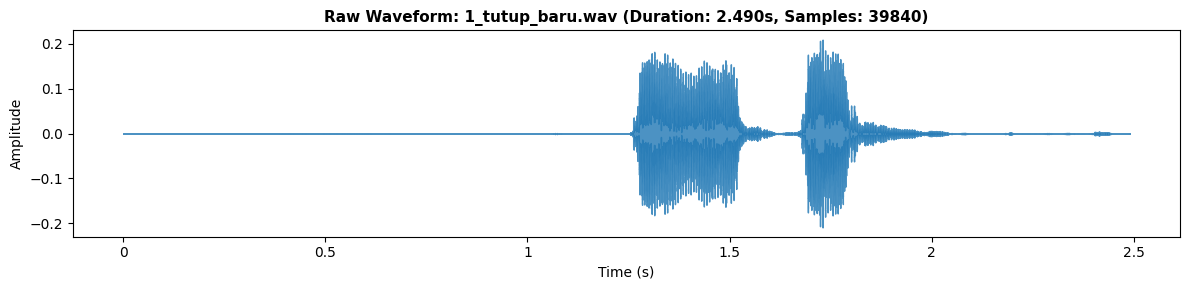

File 1: 1_tutup_baru.wav
   Min amplitude: -0.180839
   Max amplitude: 0.209365
   Mean: -0.000000
   Std Dev: 0.032107



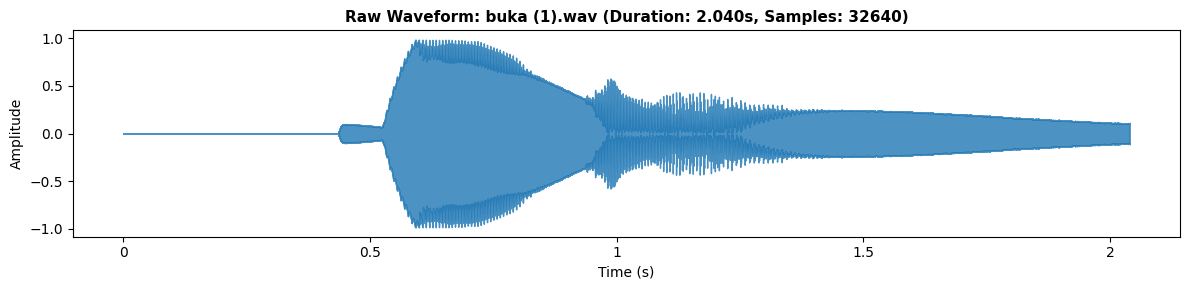

File 2: buka (1).wav
   Min amplitude: -0.984713
   Max amplitude: 0.432742
   Mean: -0.074595
   Std Dev: 0.342668



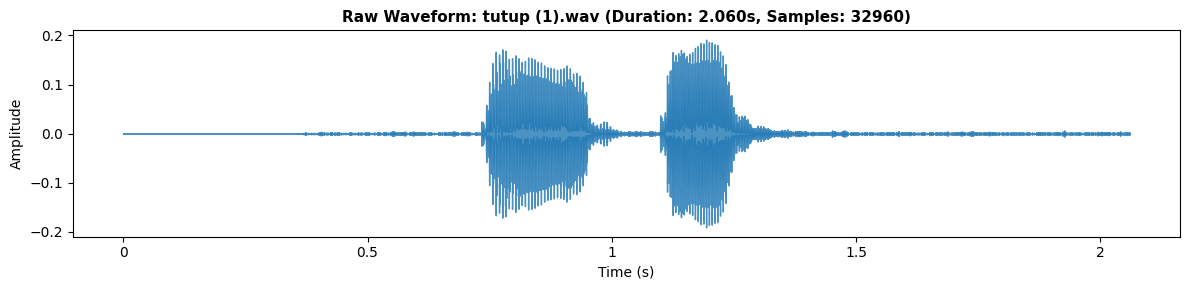

File 3: tutup (1).wav
   Min amplitude: -0.191351
   Max amplitude: 0.162461
   Mean: -0.000295
   Std Dev: 0.030170



In [ ]:
# Visualisasi raw waveform untuk beberapa file (max 3)
sample_n = min(3, len(audios))
print(f"\nVISUALISASI RAW WAVEFORM (Menampilkan {sample_n}/{len(audios)} file)\n")

for i in range(sample_n):
    info = audios[i]
    filename = info['filename']
    y = info['y']
    sr = info['sr']
    
    # Plot waveform
    plt.figure(figsize=(12, 3))
    plt.title(f"Raw Waveform: {filename} (Duration: {info['duration']:.3f}s, Samples: {info['n_samples']})", fontsize=11, fontweight='bold')
    librosa.display.waveshow(y, sr=sr, alpha=0.8)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    
    # Print statistik sinyal
    print(f"File {i+1}: {filename}")
    print(f"   Min amplitude: {np.min(y):.6f}")
    print(f"   Max amplitude: {np.max(y):.6f}")
    print(f"   Mean: {np.mean(y):.6f}")
    print(f"   Std Dev: {np.std(y):.6f}\n")

## 4. DTW Distance Calculation

In [6]:
print("\n" + "="*70)
print("MENGHITUNG PAIRWISE DTW DISTANCES (RAW AUDIO)")
print("="*70 + "\n")

n = len(audios)
dtw_matrix = np.zeros((n, n))

# Define custom distance function untuk scalar values
def scalar_distance(x, y):
    """Hitung jarak absolut untuk scalar values dari raw audio samples"""
    return abs(float(x) - float(y))

# Hitung DTW distance untuk setiap pasang audio
print("Progress perhitungan DTW:\n")
for i in range(n):
    for j in range(i + 1, n):
        # fastdtw menghitung jarak DTW antara dua sequence (raw audio signals)
        # Menggunakan custom distance function untuk scalar samples
        distance, _ = fastdtw(audios[i]['y'], audios[j]['y'], dist=scalar_distance)
        dtw_matrix[i, j] = distance
        dtw_matrix[j, i] = distance  # Matriks simetris
        
        print(f"   [{i+1},{j+1}] DTW({audios[i]['filename']}, {audios[j]['filename']}) = {distance:.2f}")

print(f"\n✓ Perhitungan DTW selesai untuk {n} file audio")
print(f"✓ Total perhitungan: {n * (n - 1) // 2} pasangan\n")


MENGHITUNG PAIRWISE DTW DISTANCES (RAW AUDIO)

🔄 Progress perhitungan DTW:

   [1,2] DTW(1_tutup_baru.wav, buka (1).wav) = 6843.44
   [1,2] DTW(1_tutup_baru.wav, buka (1).wav) = 6843.44
   [1,3] DTW(1_tutup_baru.wav, tutup (1).wav) = 287.83
   [1,3] DTW(1_tutup_baru.wav, tutup (1).wav) = 287.83
   [1,4] DTW(1_tutup_baru.wav, tutup (10).wav) = 591.35
   [1,4] DTW(1_tutup_baru.wav, tutup (10).wav) = 591.35
   [1,5] DTW(1_tutup_baru.wav, tutup (100).wav) = 597.80
   [1,5] DTW(1_tutup_baru.wav, tutup (100).wav) = 597.80
   [1,6] DTW(1_tutup_baru.wav, tutup (11).wav) = 795.15
   [1,6] DTW(1_tutup_baru.wav, tutup (11).wav) = 795.15
   [1,7] DTW(1_tutup_baru.wav, tutup (12).wav) = 526.94
   [1,7] DTW(1_tutup_baru.wav, tutup (12).wav) = 526.94
   [1,8] DTW(1_tutup_baru.wav, tutup (13).wav) = 587.69
   [1,8] DTW(1_tutup_baru.wav, tutup (13).wav) = 587.69
   [1,9] DTW(1_tutup_baru.wav, tutup (14).wav) = 638.23
   [1,9] DTW(1_tutup_baru.wav, tutup (14).wav) = 638.23
   [1,10] DTW(1_tutup_baru.wa

## 5. Output Results - Hasil Perhitungan DTW

In [7]:
# Konversi matriks DTW menjadi DataFrame untuk visualisasi yang lebih rapi
filenames = [info['filename'] for info in audios]
df_dtw = pd.DataFrame(dtw_matrix, index=filenames, columns=filenames)

print("="*70)
print("DTW DISTANCE MATRIX")
print("="*70)
print("\nTabel Jarak DTW antar Audio (menggunakan Raw Audio Signal):\n")
print(df_dtw.round(2))

# Analisis jarak terkecil dan terbesar
print("\n" + "="*70)
print("ANALISIS JARAK")
print("="*70)

# Mask diagonal dan nilai 0 untuk mencari jarak non-zero
mask = np.triu(np.ones_like(dtw_matrix, dtype=bool), k=1)
distances_nonzero = dtw_matrix[mask]

if len(distances_nonzero) > 0:
    min_distance = np.min(distances_nonzero)
    max_distance = np.max(distances_nonzero)
    mean_distance = np.mean(distances_nonzero)
    
    print(f"\nStatistik Jarak DTW:")
    print(f"   └─ Jarak minimum: {min_distance:.2f}")
    print(f"   └─ Jarak maksimum: {max_distance:.2f}")
    print(f"   └─ Jarak rata-rata: {mean_distance:.2f}")
    
    # Cari pasangan audio dengan jarak terdekat
    min_idx = np.unravel_index(np.argmin(dtw_matrix + np.eye(n) * np.inf), dtw_matrix.shape)
    print(f"\nPasangan audio terdekat:")
    print(f"   └─ {filenames[min_idx[0]]} ↔ {filenames[min_idx[1]]}")
    print(f"   └─ Jarak: {dtw_matrix[min_idx[0], min_idx[1]]:.2f}")
    
    # Cari pasangan audio dengan jarak terjauh
    max_idx = np.unravel_index(np.argmax(dtw_matrix - np.eye(n) * np.inf), dtw_matrix.shape)
    print(f"\nPasangan audio terjauh:")
    print(f"   └─ {filenames[max_idx[0]]} ↔ {filenames[max_idx[1]]}")
    print(f"   └─ Jarak: {dtw_matrix[max_idx[0], max_idx[1]]:.2f}")

print("\n")

DTW DISTANCE MATRIX

Tabel Jarak DTW antar Audio (menggunakan Raw Audio Signal):

                  1_tutup_baru.wav  buka (1).wav  tutup (1).wav  \
1_tutup_baru.wav              0.00       6843.44         287.83   
buka (1).wav               6843.44          0.00        7017.31   
tutup (1).wav               287.83       7017.31           0.00   
tutup (10).wav              591.35       7652.24         345.60   
tutup (100).wav             597.80       7916.83         324.53   
...                            ...           ...            ...   
tutup (95).wav             7658.93        971.38        7583.40   
tutup (96).wav              499.88       5810.30         414.38   
tutup (97).wav              366.63       6572.31         445.88   
tutup (98).wav              662.21       7629.16         754.58   
tutup (99).wav              408.97       7512.84         369.56   

                  tutup (10).wav  tutup (100).wav  tutup (11).wav  \
1_tutup_baru.wav          591.35           5

C:\Users\Muhammad Junaidi\AppData\Local\Temp\ipykernel_27408\3911523741.py:31: RuntimeWarning: invalid value encountered in multiply
  min_idx = np.unravel_index(np.argmin(dtw_matrix + np.eye(n) * np.inf), dtw_matrix.shape)
C:\Users\Muhammad Junaidi\AppData\Local\Temp\ipykernel_27408\3911523741.py:37: RuntimeWarning: invalid value encountered in multiply
  max_idx = np.unravel_index(np.argmax(dtw_matrix - np.eye(n) * np.inf), dtw_matrix.shape)


In [8]:
# Simpan hasil ke file CSV
print("="*70)
print("SAVE OUTPUT")
print("="*70 + "\n")

output_csv = 'dtw_distances_userA_tutup.csv'
df_dtw.to_csv(output_csv)
print(f"✓ Hasil DTW disimpan ke: {output_csv}")

# Tampilkan preview file CSV
print(f"\nPreview CSV file:")
print(f"   Path: {os.path.abspath(output_csv)}")
print(f"   Size: {os.path.getsize(output_csv)} bytes")
print(f"\n   First few rows:")
print(f"   {df_dtw.round(2).head(3).to_string()}")

print("\n" + "="*70)
print("PROGRAM SELESAI")
print("="*70)

SAVE OUTPUT

✓ Hasil DTW disimpan ke: dtw_distances_userA_tutup.csv

Preview CSV file:
   Path: d:\Penyimpanan Utama\Documents\01_Kuliah\Semester_5\Proyek_Sains_Data\Meet_11\audio-classifier-authorized\dtw_distances_userA_tutup.csv
   Size: 191664 bytes

   First few rows:
                     1_tutup_baru.wav  buka (1).wav  tutup (1).wav  tutup (10).wav  tutup (100).wav  tutup (11).wav  tutup (12).wav  tutup (13).wav  tutup (14).wav  tutup (15).wav  tutup (16).wav  tutup (17).wav  tutup (18).wav  tutup (19).wav  tutup (2).wav  tutup (20).wav  tutup (21).wav  tutup (22).wav  tutup (23).wav  tutup (24).wav  tutup (25).wav  tutup (26).wav  tutup (27).wav  tutup (28).wav  tutup (29).wav  tutup (3).wav  tutup (30).wav  tutup (31).wav  tutup (32).wav  tutup (33).wav  tutup (34).wav  tutup (35).wav  tutup (36).wav  tutup (37).wav  tutup (38).wav  tutup (39).wav  tutup (4).wav  tutup (40).wav  tutup (41).wav  tutup (42).wav  tutup (43).wav  tutup (44).wav  tutup (45).wav  tutup (46).wav  tutu

## Hasil perhitungan jarak

Berikut link CSV hasil perhitungan jarak yang sudah dilakukan:
https://drive.google.com/file/d/12a3nyhsNFH6lAQ1WEOmPT43oYyd7dvOm/view?usp=sharing